# Set up fasttext similarity Data

In [1]:
import pandas as pd
import numpy as np
import spacy
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
import pickle
from gensim.models import KeyedVectors

### Fetching lexicon and word frequencies

In [4]:
# Importing word frequency list from wikipedia
wordfreq = pd.read_csv("data/enwiki-2023-04-13.txt", sep=" ", index_col=0, header=None, names=["frequency"]).iloc[:100000]
words = wordfreq.index.tolist()

In [31]:
# Lemmatize and remove stop words from clues
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
lemmas = {nlp(str(word))[0]:word for word in reversed(words)}
lemmas = {token.lemma_:lemmas[token] for token in lemmas if token.pos_ not in ["ADP", "AUX", "CCONJ", "DET", "NUM", "PARt", "PRON", "SCONJ", "PUNCT", "SYM"]}

In [36]:
stop_words = stopwords.words("english")
with open("data/prepositions_etc.txt") as file:
    preps = file.readlines()
clues = {lemma:lemmas[lemma] for lemma in reversed(lemmas) if lemma not in stop_words and lemma not in preps}
freqs = {lemma:wordfreq.loc[clues[lemma]].frequency for lemma in clues}
freqs["nan"] = np.int64(10268+8765) # funny bug for entry nan

In [41]:
# save for later use
with open("data/word_freqs.pkl", "wb+") as file:
    pickle.dump(freqs, file)
with open("data/all_clues.pkl", "wb+") as file:
    pickle.dump(list(freqs.keys()), file)

In [51]:
# Also pickle the board words
with open("data/codewords.txt") as file:
    codewords = file.readlines()
codewords = [word.lower().replace("\n", "") for word in codewords]
with open("data/all_codewords.pkl", "wb+") as file:
    pickle.dump(codewords, file)

### Precomputing word similarities with Fasttext

For our agent, we need a precomputed cpt as well as a fitness matrix. If we use the same source (in this case, fasttext), both contain the same values except that the cpt is rescaled and normalized along axis 1 such that it represents a valid probability distribution.

In [4]:
fasttext_model = KeyedVectors.load_word2vec_format("agents/data/fasttext-wiki-news-300d-1M-subword.vec.gz")

In [5]:
with open("agents/data/all_clues.pkl", "rb") as file:
    clues = pickle.load(file)
with open("agents/data/all_codewords.pkl", "rb") as file:
    codewords = pickle.load(file)
    
def get_distances(clue):
    if not fasttext_model.has_index_for(clue):
        return np.full((len(codewords)), 1e-7)
    else:
        vec = np.abs(1 - fasttext_model.distances(clue, codewords))
        return vec

In [6]:
similarities = []
for clue in clues:
    sims = get_distances(clue)
    similarities.append(sims)
similarities = np.maximum(np.stack(similarities), 1e-7)
np.save("agents/data/fasttext_similarities.npy", similarities.astype("float16"))

In [6]:
import numpy as np
import random
import pickle

In [7]:
freqs = pickle.load(open("agents/data/word_freqs.pkl", "rb"))

In [8]:
aslist = list(freqs.values())
asarray = np.array(aslist)
l = len(aslist)
sample_list = lambda: aslist[int(random.random() * l)]
sample_array = lambda: asarray[int(random.random() * l)]

In [36]:
with open("agents/data/word_freqs.pkl", "wb") as file:
    pickle.dump(freqs, file)

# Neural network model embeddings
We also want to use word embeddings from LLMs to calculate clue fitness and CPT. We use two models: The latest embeddings model from OpenAI 

In [202]:
import numpy as np
llama_sims = np.load("agents/data/llama_embeddings_similarities.npy")
llama_probs = llama_sims / np.array([llama_sims.sum(axis=1)]).T
np.save("agents/data/llama_embeddings_cpt.npy", llama_probs)

## Asking Llama

In [93]:
slices = sorted(os.listdir("asking_llama/data"), key=lambda s: int(s.split("--")[1][:-4]))
llama_sims = [np.load(f"asking_llama/data/{s}") for s in slices]
llama_sims = np.concatenate(llama_sims)

np.save("agents/data/llama_fewshot_similarities.npy", llama_sims.astype("float16"))

In [94]:
llama_sims_corrected = np.where(np.array([llama_sims.sum(axis=1) != 0]).T, llama_sims, np.ones_like(llama_sims))
llama_probs = llama_sims_corrected / np.array([llama_sims_corrected.sum(axis=1)]).T
np.save("agents/data/llama_fewshot_cpt.npy", llama_probs.astype("float16"))

## Using SWOW

We calculated relatedness scores from Small World of Words using PPMI Random Walk with R. We can now generate the similarity table. The SWOW corpus is comparatively small (12.500 words), so we need a lot of uniform fillers for missing words. The hope is that the quality of the scores is better to make up for the missing values

In [123]:
with open("agents/data/all_clues.pkl", "rb") as file:
    clues = pickle.load(file)
with open("agents/data/all_codewords.pkl", "rb") as file:
    codewords = pickle.load(file)
with open("agents/data/SWOW_terms.txt") as file:
    terms = [word.strip().lower() for word in file.readlines()]

In [124]:
# Check which codewords are not in the SWOW corpus, which is very critical
[codeword for codeword in codewords if codeword not in terms]

['antarctica',
 'atlantis',
 'aztec',
 'beijing',
 'bermuda',
 'centaur',
 'czech',
 'greece',
 'himalayas',
 'moscow',
 'olympus',
 'roulette',
 'smuggler',
 'tokyo',
 'undertaker']

In [125]:
# Here we make the best substitution, which is sometimes completely fine and sometimes very very bad
codewords[codewords.index("antarctica")] = "antarctic"
codewords[codewords.index("atlantis")] = "fantasy"
codewords[codewords.index("aztec")] = "south america"
codewords[codewords.index("beijing")] = "china"
codewords[codewords.index("bermuda")] = "triangle"
codewords[codewords.index("centaur")] = "minotaur"
codewords[codewords.index("czech")] = "poland"
codewords[codewords.index("greece")] = "greek"
codewords[codewords.index("himalayas")] = "summit"
codewords[codewords.index("moscow")] = "russia"
codewords[codewords.index("olympus")] = "olympic"
codewords[codewords.index("roulette")] = "poker"
codewords[codewords.index("smuggler")] = "contraband"
codewords[codewords.index("tokyo")] = "japan"
codewords[codewords.index("undertaker")] = "funeral"

In [126]:
import pandas as pd
swow_table = pd.read_csv("agents/data/S_SWOW-EN.RW.A75.R123.csv", index_col=0).to_numpy()

In [142]:
sim_index = np.array([terms.index(word) for word in codewords])
na = np.full(sim_index.shape, 1e-7)
swow_sims = []
na_counter = 0
for clue in clues:
    if clue in terms:
        swow_sims.append(swow_table[terms.index(clue), sim_index])
    else:
        swow_sims.append(na)
        na_counter += 1
swow_sims = np.stack(swow_sims)
np.save("agents/data/swow_similarities.npy", swow_sims.astype("float16"))

### Testing the Codemaster

In [ ]:
import pickle
import numpy as np
from agents.rsa.rsagent import llama_Codemaster, filter_eligible_clues
codemaster = llama_Codemaster()

In [2]:
with open("agents/data/boards/board_5.pkl", "rb") as file:
    words, assocs = pickle.load(file)
    assocs2index = {"good": 0, "neutral": 1, "bad": 2, "assassin": 3}
with open("agents/data/all_codewords.pkl", "rb") as file:
    codewords = pickle.load(file)
    codewords2index = {w:i for i,w in enumerate(codewords)}
with open("agents/data/all_clues.pkl", "rb") as file:
    clues = pickle.load(file)[:10000]
words_eval = np.array([codewords2index[word] for word in words])
assocs_eval = np.array([assocs2index[assoc] for assoc in assocs])
fitness = codemaster.get_total_fitness()[:10000]

clues, fitness = filter_eligible_clues(clues, words, fitness)
codemaster.set_fitness(fitness.astype("float32"))

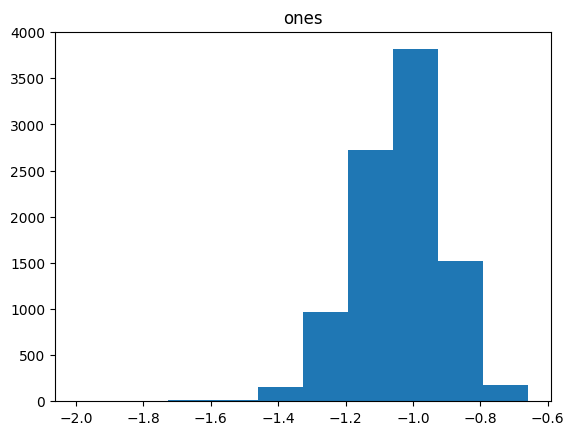

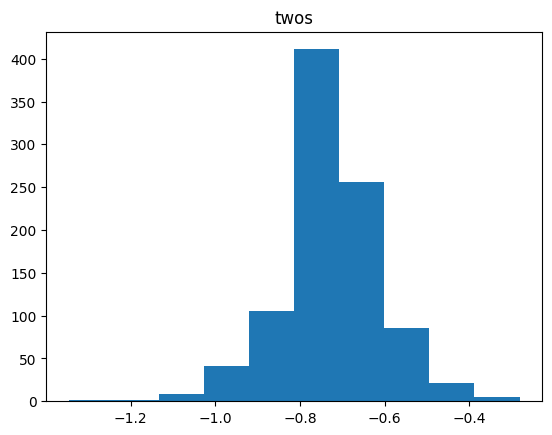

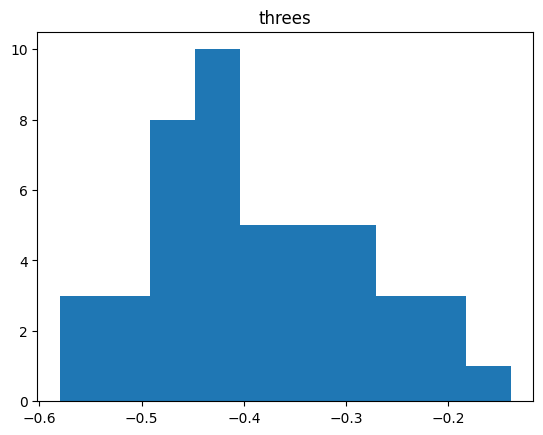

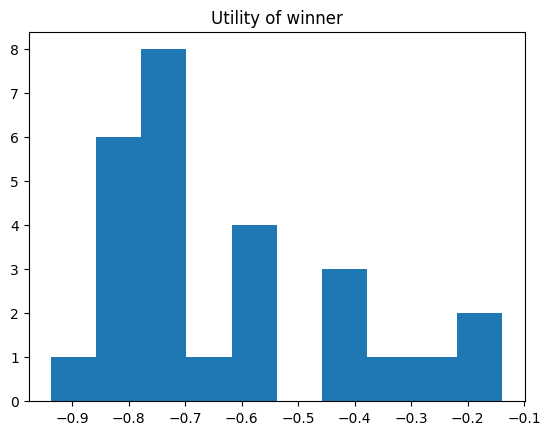

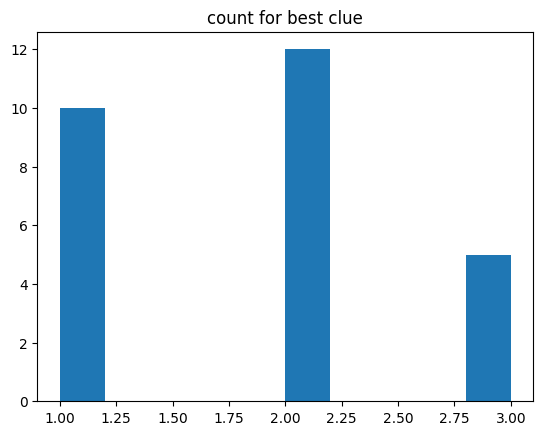

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

util = np.array([])
amount = np.array([])
best_utility = []
clue_amount = []
best_clue = []

for board in os.listdir("agents/data/boards"):
    with open(f"agents/data/boards/{board}", "rb") as file:
        words, assocs = pickle.load(file)
        words_eval = np.array([codewords2index[word] for word in words])
        assocs_eval = np.array([assocs2index[assoc] for assoc in assocs])
        new_clues, new_fitness = filter_eligible_clues(clues, words, fitness)
        codemaster.set_fitness(new_fitness.astype("float32"))
        clue, count, util_new, amount_new = codemaster.eval(words_eval, assocs_eval)
        best_utility.append(util_new[clue])
        clue_amount.append(count)
        best_clue.append(new_clues[clue])
        e_util, e_amount = util_new[util_new > util_new.min()], amount_new[util_new > util_new.min()]
        util = np.concatenate((util, e_util))
        amount = np.concatenate((amount, e_amount))

ones = util[amount == 1]
twos = util[amount == 2]
threes = util[amount == 3]
fours = util[amount == 4]

plt.hist(ones)
plt.title("ones")
plt.show()
plt.hist(twos)
plt.title("twos")
plt.show()
plt.hist(threes)
plt.title("threes")
plt.show()
plt.hist(best_utility)
plt.title("Utility of winner")
plt.show()
plt.hist(clue_amount)
plt.title("count for best clue")
plt.show()

In [4]:
best_clue

['leisure',
 'sharia',
 'measure',
 'rabbis',
 'personnel',
 'rajesh',
 'fibrous',
 'sardinia',
 'spalde',
 'racial',
 'chassis',
 'triassic',
 'mcculloch',
 'eastman',
 'hwang',
 'plc',
 'monitor',
 'gil',
 'eyesight',
 'rostock',
 'canyon',
 'calibration',
 'scunthorpe',
 'wholesale',
 'compliance',
 'piston',
 'lesotho']

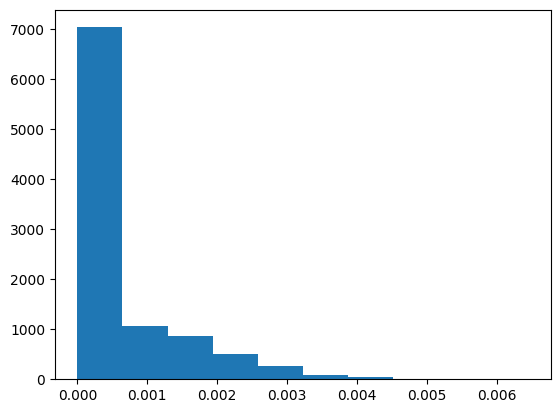

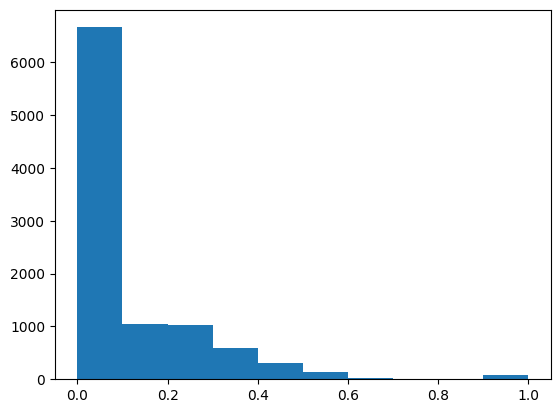

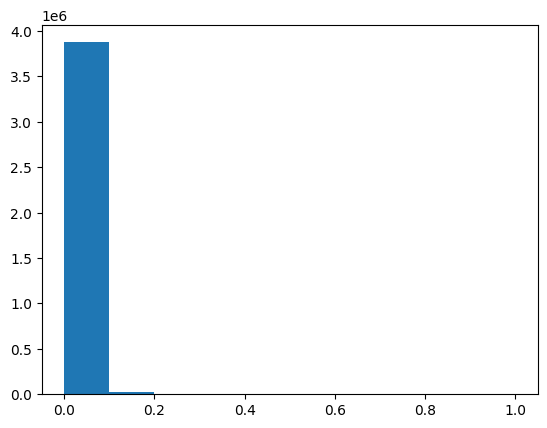

In [5]:
plt.hist(fitness.min(axis=1))
plt.show()
plt.hist(fitness.max(axis=1))
plt.show()
plt.hist(fitness.flatten())
plt.show()

In [14]:
import timeit
timeit.timeit(lambda: codemaster.eval(words_eval, assocs_eval), number=10000) / 10000

0.003736393479997059

In [7]:
with open("agents/data/word_freqs.pkl", "rb") as file:
    freqs = pickle.load(file)
np.array(list(freqs.values()))

array([6570012, 2571348, 1700124, ...,    4770,   48055,     499],
      dtype=int64)

In [5]:
llama = np.load("agents/data/llama_embeddings_similarities.npy")

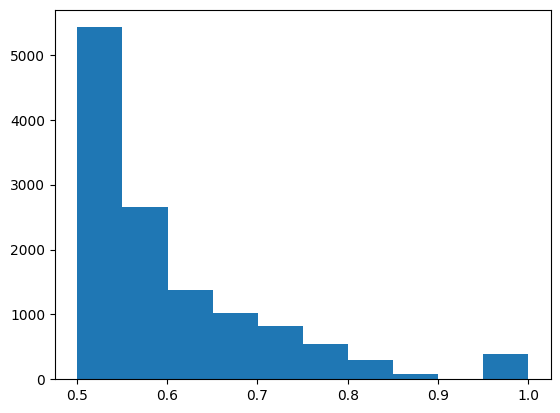

In [9]:
flama = llama.flatten()
flsorted = flama.argsort()
florted = flama[flsorted]
plt.hist(florted[florted > .5])
plt.show()

In [70]:
np.abs(get_distances("tpp")).sum()

132.67612

In [7]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [8]:
test1 = np.array([1, 2, 3])
softmax(test1)

array([0.09003057, 0.24472847, 0.66524096])

In [12]:
np.exp(float("inf"))

inf

## Test Codemaster and Guesser speed

In [ ]:
from timeit import timeit
import numpy as np
from agents.rsa.rsagent import openai_Codemaster, openai_Guesser, filter_eligible_clues
import pickle
from matplotlib import pyplot as plt
guesser = openai_Guesser()
codemaster = openai_Codemaster()

In [19]:
with open("agents/data/boards/board_3.pkl", "rb") as file:
    words, assocs = pickle.load(file)
    assocs2index = {"good": 0, "neutral": 1, "bad": 2, "assassin": 3}
with open("agents/data/all_codewords.pkl", "rb") as file:
    codewords = pickle.load(file)
    codewords2index = {w:i for i,w in enumerate(codewords)}
with open("agents/data/all_clues.pkl", "rb") as file:
    clues = pickle.load(file)[:20000]
words_eval = np.array([codewords2index[word] for word in words])
assocs_eval = np.array([assocs2index[assoc] for assoc in assocs])
fitness = codemaster.get_total_fitness()[:20000]
clues, fitness = filter_eligible_clues(clues, words, fitness)
codemaster.set_fitness(fitness.astype("float32"))
guesser.set_fitness(fitness.astype("float32"))
clue, count, util, counts = codemaster.eval(words_eval, assocs_eval)
guesser.set_board_words(words_eval)
guesser.set_clue(clue, count)
guesser.set_assoc_ordering(np.sort(assocs_eval)[::-1].astype("int64"))
guesser.calculate_codemaster_prob(assocs_eval)
count

3

In [11]:
samples, trace = guesser.run_mcmc(2000, 100_000)

In [47]:
with open("trace_1000000.pkl", "rb") as file:
    (samples, trace) = pickle.load(file)

In [48]:
mcmc = (np.stack(samples) == 0).sum(axis=0)
mcmcee = mcmc / mcmc.max()
mcmc = mcmcee.reshape((5,5))
assocs = assocs_eval.reshape((5,5))

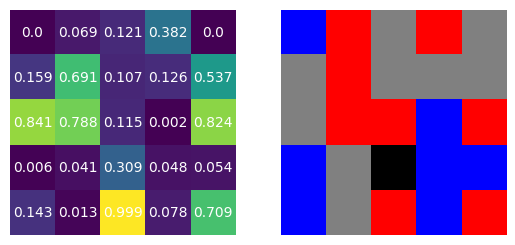

In [49]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['red', 'grey', 'blue', 'black'])
fig, (ax1, ax2) = plt.subplots(1, 2)
mcmc_plot = mcmc.copy()
maxes = []
for i in range(count):
    idx = mcmc_plot.argmax()
    maxes.append(idx)
    mcmc_plot[np.unravel_index(idx, mcmc.shape)] = mcmc_plot.min()
ax1.imshow(mcmc_plot)
ax1.axis("off")
for i in range(5):
    for j in range(5):
        text = ax1.text(j, i, str(mcmc[i, j])[:5],
                       ha="center", va="center", color="w")
ax2.imshow(assocs, cmap=cmap)
"""for i in range(5):
    for j in range(5):
        text = ax2.text(j, i, assocs[i, j],
                       ha="center", va="center", color="w")"""
plt.axis('off')
plt.savefig("mcmc.svg", bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

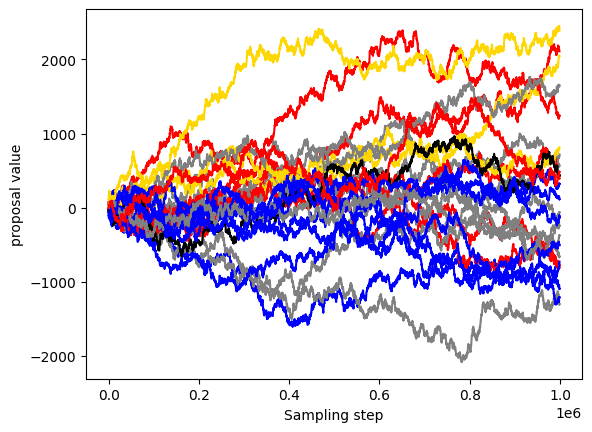

In [41]:
from scipy.signal import savgol_filter
stacktrace = np.stack(trace)
x_range = np.arange(stacktrace.shape[0])
for x in range(stacktrace.shape[1]):
    smoothed = savgol_filter(stacktrace[:, x], window_length=500,polyorder=3,mode='mirror')
    # smoothed = stacktrace[:, x]
    x_range = np.arange(smoothed.shape[0])
    color = "gold" if x in maxes else ["red", "grey", "blue", "black"][assocs_eval[x]]
    plt.plot(x_range, smoothed, color=color)
plt.xlabel("Sampling step")
plt.ylabel("proposal value")
plt.savefig("trace_1m.svg")
plt.show()


In [16]:
trace[0]

array([2, 1, 1, 1, 1, 0, 1, 0, 1, 2, 0, 2, 1, 2, 1, 2, 1, 0, 2, 0, 0, 0,
       3, 2, 0], dtype=int64)

In [26]:
from tqdm import tqdm
import os

guesser = fasttext_Guesser()
codemaster = fasttext_Codemaster()

best_guesses = []

for board in tqdm(os.listdir("agents/data/boards")):
    with open(f"agents/data/boards/{board}", "rb") as file:
        words, assocs = pickle.load(file)
        words_eval = np.array([codewords2index[word] for word in words])
        assocs_eval = np.array([assocs2index[assoc] for assoc in assocs])
        new_clues, new_fitness = filter_eligible_clues(clues, words, guesser.get_fitness())
        words_eval = np.array([codewords2index[word] for word in words])
        assocs_eval = np.array([assocs2index[assoc] for assoc in assocs])
        fitness = codemaster.get_total_fitness()[:10000]
        clues, fitness = filter_eligible_clues(clues, words, fitness)
        codemaster.set_fitness(fitness.astype("float32"))
        guesser.set_fitness(fitness.astype("float32"))
        clue, count, util, counts = codemaster.eval(words_eval, assocs_eval)
        guesser.set_board_words(words_eval)
        guesser.set_clue(clue, count)
        guesser.set_assoc_ordering(np.sort(assocs_eval)[::-1].astype("int64"))
        samples = guesser.run_mcmc(200, 100_000)
        mcmc = (np.stack(samples) == 0).sum(axis=0)
        best_guesses.append(assocs_eval[mcmc.argsort()[::-1]][:count].tolist())

print(best_guesses)

100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [40:25<00:00, 89.85s/it]

[[0, 0], [0, 0, 0], [0, 0], [0, 0], [0, 2], [0, 0], [0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0, 0], [0, 0], [1, 0], [0, 0], [0, 0, 0], [0, 0], [0, 0], [2, 0], [2, 0], [1, 0, 1], [0, 0], [0, 0], [1, 1], [1, 0], [0, 0]]


In [6]:
print(timeit(lambda: codemaster.eval(words_eval, assocs_eval), number=1000) / 1000)
print(timeit(lambda: guesser.calculate_codemaster_prob(assocs_eval), number=1000) / 1000)

0.0011299779999999373
0.0003208710999997493


# Creating the boards
We do not want to create each board randomly every time (although this is how Codenames is usually played). Instead, we take pregenerated boards so we can retest a configuration on the same boards and also have a set of standardized boards for testing. In this case, we take the same boards that were used for Autobots.

In [2]:
import pickle
import pathlib

In [53]:
with open("agents/data/all_codewords.pkl", "rb") as file:
    codewords = pickle.load(file)

In [59]:
for board_file in pathlib.Path("agents/data/boards_autobots").glob("*"):
    with open(board_file.relative_to(""), "r") as board:
        lines = board.readlines()
        words, assocs = eval(lines[0]), eval(lines[1])
        words = [word.lower() for word in words]
        if not all(word in codewords for word in words):
            continue
        assocs = [assoc.replace("Red", "good").replace("Blue", "bad").replace("Civilian", "neutral").replace("Assassin", "assassin") for assoc in assocs]
        with open(f"agents/data/boards/{board_file.stem}.pkl", "wb+") as file:
            pickle.dump((words, assocs), file)

In [3]:
all_terms = []
for board_file in pathlib.Path("agents/data/boards_autobots").glob("*"):
    with open(board_file.relative_to(""), "r") as board:
        lines = board.readlines()
        words, assocs = eval(lines[0]), eval(lines[1])
        words = [word.lower() for word in words]
        all_terms += words

## Creating boards for human testing

Since we adapt the game slightly for human testing, we need to create new boards. We also want to construct these boards such that each codeword only appears on one board in total. We have a list of roughly 400 codewords, and we want to create 2 sets of 10 boards with 16 board words each which means we can satisfy this constraint.

In [17]:
import pickle
import random
import json

In [12]:
with open("agents/data/all_codewords.pkl", "rb") as file:
    codewords = pickle.load(file)
random.shuffle(codewords)

In [25]:
boards = [codewords[i*16:(i*16)+16] for i in range(20)]
assocs = [random.sample([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0], 16) for _ in range(20)]
items = [{"words": boards[i], "assoc": assocs[i], "item": i} for i in range(20)]
human_list_1 = items[:5]
human_list_2 = items[5:10]
bot_list_1 = items[10:15]
bot_list_2 = items[15:]

with open("../exp/src/human_list_1.json", "w+") as file:
    json.dump(human_list_1, file)
with open("../exp/src/human_list_2.json", "w+") as file:
    json.dump(human_list_2, file)
with open("../exp/src/bot_list_1.json", "w+") as file:
    json.dump(bot_list_1, file)
with open("../exp/src/bot_list_2.json", "w+") as file:
    json.dump(bot_list_2, file)

In [18]:
from agents.rsa.rsagent import openai_Codemaster, Codemaster_Wrapper
from agents.others.gpt import ai_codemaster_simple as ai_codemaster
import pickle
import json
import numpy as np
from copy import deepcopy

with open("../exp/src/bot_list_1.json", "r") as file:
    boards_1 = json.load(file)
with open("../exp/src/bot_list_2.json", "r") as file:
    boards_2 = json.load(file)
boards_rsa = boards_1 + boards_2
boards_other = deepcopy(boards_rsa)
with open("agents/data/all_codewords.pkl", "rb") as file:
    codewords = pickle.load(file)
with open("agents/data/all_clues.pkl", "rb") as file:
    clues = pickle.load(file)[:20000]

In [19]:
agent = Codemaster_Wrapper(openai_Codemaster(), clues, codewords)
agent.codemaster.weights = np.array([1, -1.7, -1.7, -1.7]).astype("float32")
for board in boards_rsa:
    new_assoc = ["good" if x == 1 else "neutral" for x in board["assoc"]]
    clue, count = agent.give_clue(board["words"], new_assoc)
    board["clue"] = clue
    board["count"] = count
    board["agent"] = "RSA-openai"

In [20]:
clues.remove("however")
other = ai_codemaster(clues)
for board in boards_other:
    new_words = board["words"] + ["*"] * 9
    new_assoc = ["Red" if x == 1 else "Civilian" for x in board["assoc"]]
    other.receive_game_state(new_words, new_assoc)
    clue, count = other.give_clue()
    board["clue"] = clue
    board["count"] = int(count)
    board["agent"] = "other-GPT-weighted"

c:\Users\flohk\Anaconda3\envs\CodenamesRSA\Lib\site-packages\transformers\models\auto\modeling_auto.py:1712: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [21]:
agent_list_1 = boards_rsa[:5] + boards_other[5:]
agent_list_2 = boards_other[:5] + boards_rsa[5:]

with open("../exp/src/agent_list_1.json", "w+") as file:
    json.dump(agent_list_1, file)
with open("../exp/src/agent_list_2.json", "w+") as file:
    json.dump(agent_list_2, file)